In [117]:
import torch
import random
from tqdm import tqdm
from diffusers import AutoencoderDC, SanaTransformer2DModel
from transformers import AutoModel, AutoTokenizer, set_seed
from utils import cifar10_labels, encode_prompt, get_sigma_schedule, latent_to_PIL, dcae_scalingf, make_grid, linear_multistep_coeff

In [2]:
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [6]:
repo_transformer="g-ronimo/hana-alpha22"
repo_te = "answerdotai/ModernBERT-large"
repo_ae = "Efficient-Large-Model/Sana_600M_1024px_diffusers"

transformer = SanaTransformer2DModel.from_pretrained(repo_transformer).to(device).to(dtype)
te = AutoModel.from_pretrained(repo_te, torch_dtype=dtype).to(device)
tok = AutoTokenizer.from_pretrained(repo_te, torch_dtype=dtype)
dcae = AutoencoderDC.from_pretrained(repo_ae, subfolder="vae", torch_dtype=dtype).to(device)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


In [32]:
def generate(prompt, tokenizer, text_encoder, latent_dim=None, num_steps=100, latent_seed=None):
    assert latent_dim is not None
    prompt_encoded, prompt_atnmask = encode_prompt(str(prompt), tokenizer, text_encoder)
    latent = torch.randn(latent_dim, generator=torch.manual_seed(latent_seed) if latent_seed else None).to(dtype).to(device)
    sigmas, timesteps = get_sigma_schedule(num_steps)

    for t, sigma_prev, sigma_next in zip(timesteps, sigmas[:-1], sigmas[1:]):
        t = t[None].to(latent.dtype).to(device)
        with torch.no_grad():
            noise_pred = transformer(
                latent, 
                timestep=t, 
                encoder_hidden_states=prompt_encoded, 
                encoder_attention_mask=prompt_atnmask, 
                return_dict=False
            )[0]
        latent = latent + (sigma_next - sigma_prev) * noise_pred 

    return latent_to_PIL(latent / dcae_scalingf, dcae)

def generate_lms(prompt, tokenizer, text_encoder, latent_dim=None, num_steps=100, order=2, latent_seed=None):
    prompt_encoded, prompt_atnmask = encode_prompt(str(prompt), tokenizer, text_encoder)
    latent = torch.randn(latent_dim, generator=torch.manual_seed(latent_seed) if latent_seed else None).to(dtype).to(device)
    sigmas, timesteps = get_sigma_schedule(num_steps)
    ds = []
    for i in range(len(sigmas) - 1):
        t = timesteps[None, i].to(device)
        with torch.no_grad():
            noise_pred = transformer(
                latent, 
                timestep=t, 
                encoder_hidden_states=prompt_encoded, 
                encoder_attention_mask=prompt_atnmask, 
                return_dict=False
            )[0]
        ds.append(noise_pred)
        if len(ds) > order: ds.pop(0)
        cur_order = min(i + 1, order)
        coeffs = [linear_multistep_coeff(cur_order, sigmas, i, j) for j in range(cur_order)]
        latent = latent + sum(coeff * d for coeff, d in zip(coeffs, reversed(ds)))
    return latent_to_PIL(latent / dcae_scalingf, dcae)

100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.76s/it]


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


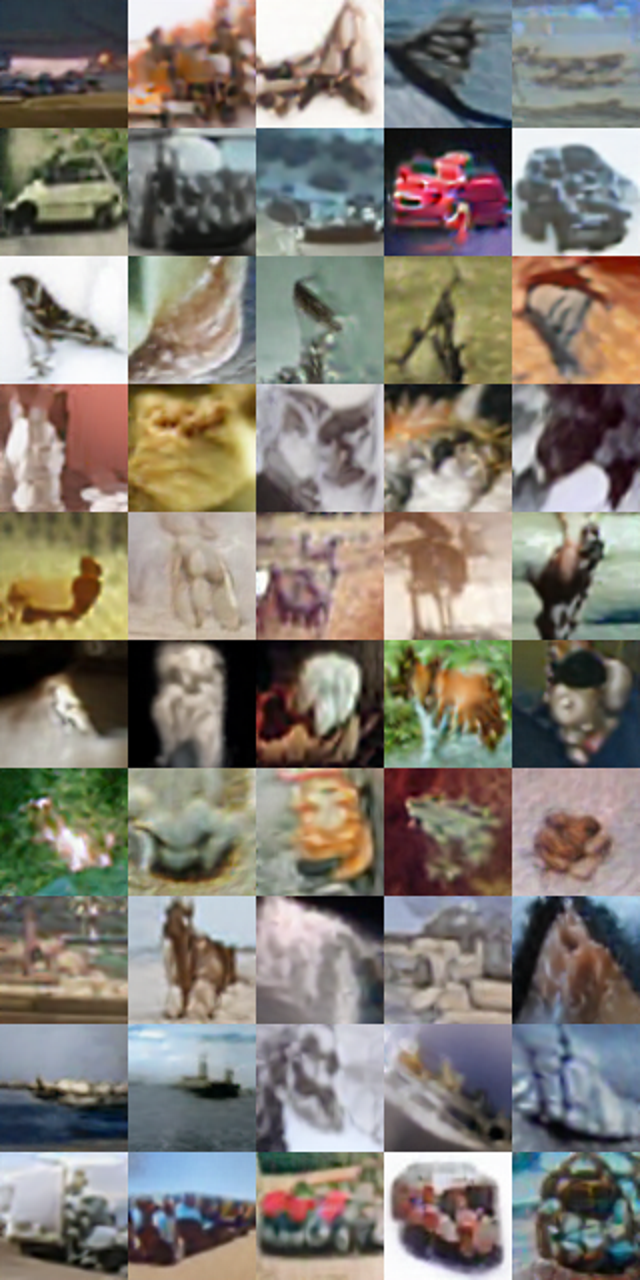

In [126]:
generation_args = dict(
    tokenizer = tok,
    text_encoder = te,
    latent_dim=[1,32,2,2],
)
labels = [cifar10_labels[k] for k in cifar10_labels]
num_imgs_per_label = 5

images = [generate_lms(
    label, 
    num_steps=20, 
    latent_seed=random.randint(0,10000),
    **generation_args
) for label in tqdm(labels) for _ in range(num_imgs_per_label) ]
print(labels)
make_grid(images, len(labels), num_imgs_per_label).resize((128*num_imgs_per_label, 128*len(labels)))